In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.infer.mcmc import MCMC, HMC, NUTS, mcmc_kernel

from pyro.optim import Adam
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')

assert pyro.__version__.startswith('1.8.1')
pyro.set_rng_seed(0)

In [2]:
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

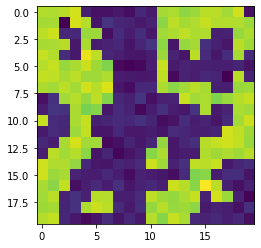

In [22]:
np.random.seed(1)
n = 10
l = 20
im = np.zeros((l, l))  # im lxl
points = l*np.random.random((3, n**2))

im[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 20 # random noise
#plt.imshow(np.reshape(im, (256,256)))

im = ndimage.gaussian_filter(im, sigma=l/(2.*n))
plt.imshow(np.reshape(im, (l,l)))

mask = (im > im.mean()).astype(np.float)
img = mask*20 + 0.8*np.random.randn(*mask.shape)
plt.imshow(np.reshape(img, (l,l)))



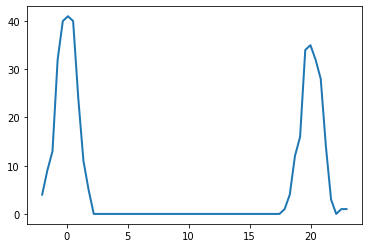

In [23]:
hist, bin_edges = np.histogram(img, bins=60)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
plt.plot(bin_centers, hist, lw=2)


In [24]:
def model(data):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", Beta(1, alpha))

    with pyro.plate("mu_plate", T):
        mu = pyro.sample("mu", Normal(0., 5.))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(mix_weights(beta))) 
        pyro.sample("obs", Normal(mu[z], 1.), obs=data)

    return beta,mu,z

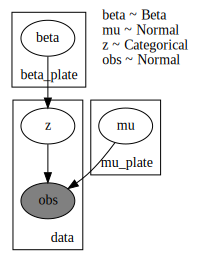

In [25]:
T = 6
N = 400
alpha = 0.05

data = torch.reshape(torch.tensor(img), (-1,)).float()
N = data.shape[0]
pyro.render_model(model, model_args=(data,), render_distributions=True)

In [26]:
pyro.clear_param_store()
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, warmup_steps=500, num_samples=200, num_chains=1)
mcmc.run(data=data)
mcmc.summary()

Sample: 100%|██████████| 700/700 [04:44,  2.46it/s, step size=2.12e-01, acc. prob=0.856]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.45      0.02      0.45      0.42      0.49    204.30      1.00
   beta[1]      1.00      0.00      1.00      1.00      1.00    106.48      1.02
   beta[2]      0.92      0.20      1.00      0.71      1.00    167.25      1.00
   beta[3]      0.92      0.19      1.00      0.70      1.00    168.12      1.01
   beta[4]      0.91      0.17      1.00      0.67      1.00    190.11      1.00
     mu[0]     20.08      0.07     20.07     19.96     20.19    152.32      1.00
     mu[1]     -0.03      0.07     -0.03     -0.14      0.10    103.31      1.03
     mu[2]      0.14      4.52      0.07     -7.04      7.59    183.18      1.00
     mu[3]      0.42      4.48      0.51     -7.09      6.94    228.94      1.00
     mu[4]     -0.64      4.63     -1.15     -7.78      6.94    178.56      1.01
     mu[5]     -0.66      4.52     -0.67     -7.85      6.49    195.27      1.01

Number of divergences: 1


In [27]:
mcmc_samples = mcmc.get_samples(group_by_chain=True)

beta = mcmc_samples['beta'][0]
mu = mcmc_samples['mu'][0]
#sigma = mcmc_samples['sigma'][0]

torch.Size([1, 200, 6])


<AxesSubplot:ylabel='Density'>

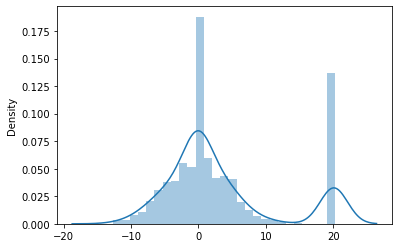

In [28]:
import seaborn as sns

print(mcmc_samples['mu'].shape)
sns.distplot(mcmc_samples["mu"])

In [15]:
print(beta[400])
print(mu[300])
print(mix_weights(beta[400]))
print(Categorical(mix_weights(beta[400])).sample([1]))
print(mu[400])

tensor([0.9999, 0.9998, 1.0000, 0.9566, 1.0000])
tensor([ 0.4512,  1.4713,  5.9796, -3.5902, -2.7223, -4.3064])
tensor([9.9994e-01, 5.5661e-05, 9.4503e-09, 1.0777e-15, 4.8858e-17, 1.5435e-21])
tensor([0])
tensor([ 0.4963, -0.3330,  3.5077,  2.7781, -3.5926, -7.5180])


In [29]:
from scipy.stats import norm 

w = mix_weights(beta)[-1]
n_samples = mu.shape[0]
n = data.shape[0]
cluster = np.zeros(n)

for i in range(n):
    q = torch.zeros(T)
    for j in range(T):
        q[j] = w[j]*norm.pdf(data[i], mu[-1][j], 1.) + q[j]

    cluster[i] = np.argmax(q)

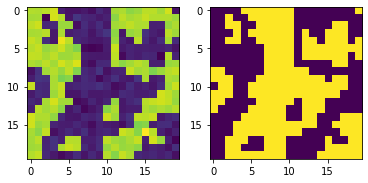

In [33]:
fig = plt.figure()
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122) 

ax1.imshow( np.reshape(data, (20,20)))
ax2.imshow( np.reshape(cluster, (20,20)))
